In [10]:
"""
Zuerst stellen wir sicher, dass die notwendigen Pakete installiert sind und importieren diese:
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

from collections import Counter


import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

In [11]:
"""
Nun definieren wir Transformatoren für die Daten, laden das Dataset und teilen diese in Trainings- und Validierungsätze auf:
"""
# Definieren Sie Transformationen für das Training und die Validierung
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Laden des FGVC-Aircraft-Datensatzes
train_dataset = torchvision.datasets.ImageFolder(root='Data/Train', transform=transform["train"])
test_dataset = torchvision.datasets.ImageFolder(root='Data/Test', transform=transform["test"])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

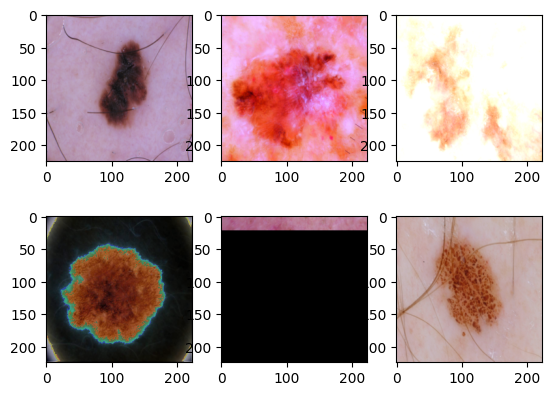

In [12]:
# look at one batch of images
examples = iter(train_loader) # create iterable object
samples, labels = next(examples)  # unpack the batch
# make a plot
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow((samples[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

In [13]:
# Device configuration, Prüfe ob GPU verfügbar ist, falls ja, lasse das Modell auf eie GPU laufen, ansonsten CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Wähle ein Modell aus unter: https://pytorch.org/vision/main/models.html
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# mit diesem Code snippet können wir die Parmeter freeze, sodass diese nicht gelernt werden. Ziel Wir trainieren nur den letzten layer, den wir am Ende hinzufügen.
"""
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False
"""
# Klassifikator ersetzen
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(train_dataset.classes))  # = 9 Klassen




model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

📊 Bilder pro Klasse:
  Klasse 0: 114 Bilder
  Klasse 1: 376 Bilder
  Klasse 2: 95 Bilder
  Klasse 3: 438 Bilder
  Klasse 4: 357 Bilder
  Klasse 5: 462 Bilder
  Klasse 6: 77 Bilder
  Klasse 7: 181 Bilder
  Klasse 8: 139 Bilder

⚖️ Gewichtung für CrossEntropyLoss:
  Klasse 0: Gewicht = 19.6404
  Klasse 1: Gewicht = 5.9548
  Klasse 2: Gewicht = 23.5684
  Klasse 3: Gewicht = 5.1119
  Klasse 4: Gewicht = 6.2717
  Klasse 5: Gewicht = 4.8463
  Klasse 6: Gewicht = 29.0779
  Klasse 7: Gewicht = 12.3702
  Klasse 8: Gewicht = 16.1079


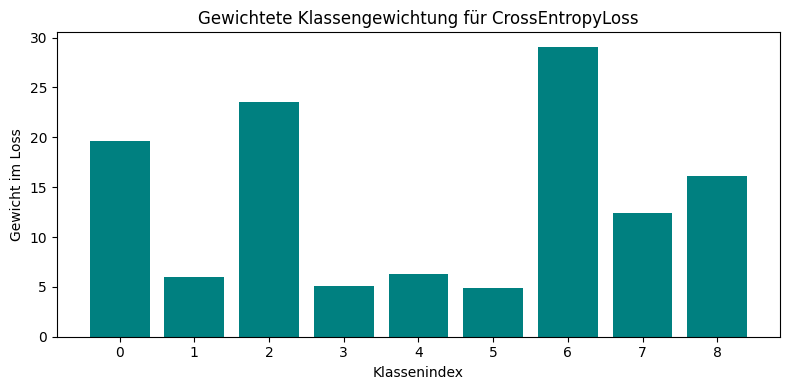

In [15]:
"""
Berechnung klassengewichteter CrossEntropyLoss für unbalancierte Datensätze.

Ziel:
-----
Bei stark ungleich verteilten Klassen im Trainingsdatensatz werden hier
Gewichte pro Klasse berechnet und in den Loss integriert. Dadurch werden
Fehlklassifikationen seltener Klassen stärker bestraft.

Ablauf:
-------
1. class_counts:
   Zähle, wie viele Bilder pro Klasse im Trainingsdatensatz vorhanden sind.

2. class_weights:
   Berechne für jede Klasse das Gewicht als total_samples / class_count.
   → Seltener = höheres Gewicht.

3. weights_tensor:
   Wandle die Liste der Gewichte in einen FloatTensor um und übergebe sie an
   nn.CrossEntropyLoss(weight=...), damit der Loss während des Trainings diese
   Gewichtung berücksichtigt.

4. Logging:
   Ausgabe der Bilderanzahl pro Klasse und der berechneten Gewichtung
   zur Kontrolle.

5. Visualisierung (optional):
   Plot der Gewichte als Balkendiagramm, um die Klassengewichtung visuell
   nachzuvollziehen.

Hinweis:
--------
Diese Methode ersetzt das Shuffling im DataLoader nicht, sondern beeinflusst
die Verlustfunktion direkt. Alternativ kann auch ein WeightedRandomSampler
verwendet werden (siehe andere Variante).
"""

# Zähle Bilder pro Klasse
class_counts = Counter([label for _, label in train_dataset])
total = sum(class_counts.values())
class_weights = [total / class_counts[i] for i in range(len(class_counts))]

# Gewichts-Tensor für den Loss
weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Zeige Bildanzahl pro Klasse
print(" Bilder pro Klasse:")
for i in range(len(class_counts)):
    print(f"  Klasse {i}: {class_counts[i]} Bilder")

# Zeige Gewicht pro Klasse
print("\n Gewichtung für CrossEntropyLoss:")
for i, w in enumerate(class_weights):
    print(f"  Klasse {i}: Gewicht = {w:.4f}")

# Optional: Visualisiere Gewichtung
plt.figure(figsize=(8, 4))
plt.bar(range(len(class_weights)), class_weights, color='teal')
plt.xlabel("Klassenindex")
plt.ylabel("Gewicht im Loss")
plt.title("Gewichtete Klassengewichtung für CrossEntropyLoss")
plt.xticks(range(len(class_weights)))
plt.tight_layout()
plt.show()


In [ ]:
"""
Trainieren des Modells
"""
# Trainingsschleife
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(train_loader)
    nr_samples = 0
    labels_global = []
    preds_global = []
    for idx, (images, labels) in enumerate(pbar, start=1):
        # Vorhersage und Verlust berechnen
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Gradienten zurücksetzen, Backwardpropagation und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        nr_samples += images.shape[0]
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels)
        labels_global.extend(labels.tolist())
        preds_global.extend(preds.tolist())
        cnt_acc = running_corrects/nr_samples
        cnt_loss = running_loss/nr_samples
        f1 = f1_score(labels_global, preds_global, average='micro')
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cnt_loss:.3f}, Acc: {cnt_acc:.3f}, F1-Score: {f1:.3f}')


Epoch [1/10], Loss: 1.721, Acc: 0.349, F1-Score: 0.349: 100%|██████████| 35/35 [02:37<00:00,  4.50s/it]
  0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [2/10], Loss: 1.294, Acc: 0.483, F1-Score: 0.483: 100%|██████████| 35/35 [02:38<00:00,  4.52s/it]
  0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [3/10], Loss: 1.067, Acc: 0.560, F1-Score: 0.560: 100%|██████████| 35/35 [02:41<00:00,  4.61s/it]
  0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packag

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
errors = []
model.eval()
running_corrects = 0
nr_samples = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels)
    nr_samples += images.shape[0]
    if preds != labels:
      errors.append({"image":images.to("cpu")[0], "y_hat":preds.to("cpu")[0].item(), "label":labels.to("cpu")[0].item()})
print()
print(f"Accuracy on Test dataset: {(running_corrects/nr_samples)*100:.3f} %")

In [ ]:
idx = 1
print(f"Label: {errors[idx]['label']}, Prediction: {errors[idx]['y_hat']}")
plt.imshow((errors[idx]['image'].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()